# Setup

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
import keras
import tensorflow as tf

from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from wordcloud import WordCloud, STOPWORDS
from string import punctuation
from imblearn.over_sampling import RandomOverSampler

from keras.preprocessing import text
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.utils import pad_sequences

import warnings
warnings.filterwarnings("ignore")

# Prepare the data

In [15]:
df1 = pd.read_csv('../dataset/Stress.csv')
df1['text'] = df1['subreddit'] + ' ' + df1['text']
df1 = df1[['text', 'label']]
df1.head()

,text,label
0,"ptsd He said he had not felt that way before, ...",1
1,"assistance Hey there r/assistance, Not sure if...",0
2,ptsd My mom then hit me with the newspaper and...,1
3,"relationships until i met my new boyfriend, he...",1
4,survivorsofabuse October is Domestic Violence ...,1


In [16]:
df2 = pd.read_csv('../dataset/Mental-Health-Twitter.csv')
df2.rename(columns={'post_text':'text'}, inplace=True)
df2 = df2[['text', 'label']]
df2.head()

,text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [17]:
df3 = pd.read_csv('../dataset/depression_dataset_reddit_cleaned.csv')
df3.rename(columns={'clean_text':'text', 'is_depression':'label'}, inplace=True)
df3.head()

,text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [18]:
df4 = pd.read_csv('../dataset/dataset.csv')
df4.head()

,text,label
0,oh my gosh,1
1,"trouble sleeping, confused mind, restless hear...",1
2,"All wrong, back off dear, forward doubt. Stay ...",1
3,I've shifted my focus to something else but I'...,1
4,"I'm restless and restless, it's been a month n...",1


In [19]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.head()

,text,label
0,"ptsd He said he had not felt that way before, ...",1
1,"assistance Hey there r/assistance, Not sure if...",0
2,ptsd My mom then hit me with the newspaper and...,1
3,"relationships until i met my new boyfriend, he...",1
4,survivorsofabuse October is Domestic Violence ...,1


In [20]:
df.dropna(inplace=True)

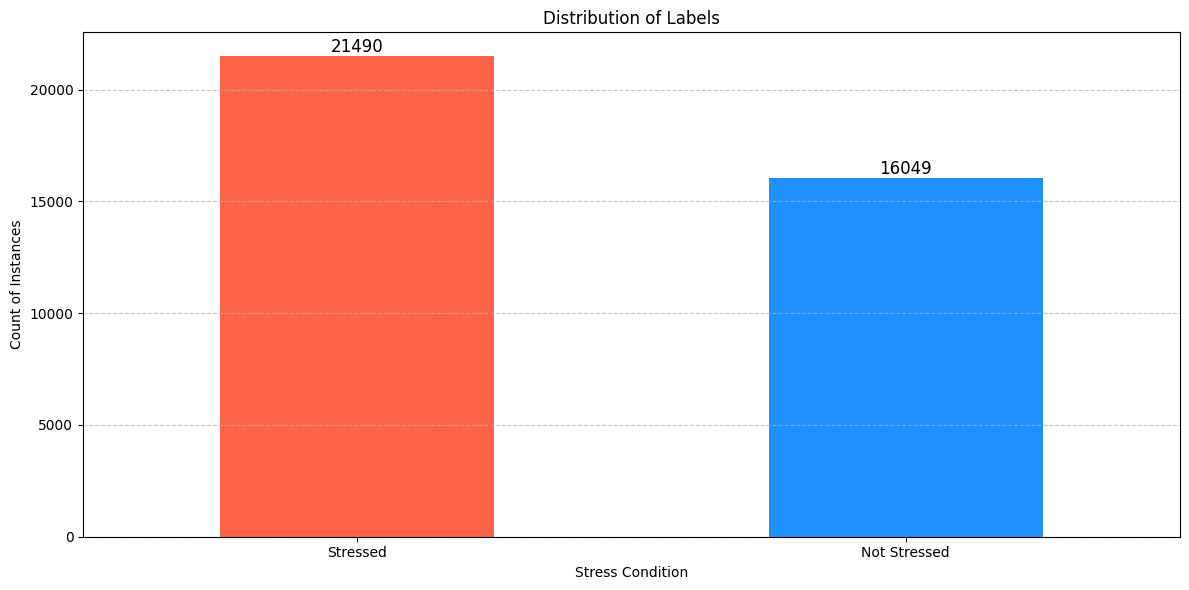

In [21]:
plt.figure(figsize=(12, 6))
colors = ['#FF6347', '#1E90FF']
df['label'].value_counts().plot(kind='bar', color=colors)
for i, txt in enumerate(df['label'].value_counts()):
    plt.text(i, txt, txt, ha='center', va='bottom', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Stressed', 'Not Stressed'], rotation=0)
plt.xlabel('Stress Condition')
plt.ylabel('Count of Instances')
plt.title('Distribution of Labels')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Preprocess

In [22]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = text.encode('utf-8', errors='ignore').decode('utf-8')
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|rt|wa|co|bit|ly', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def wnl_lemmatize(text):
    wnl = WordNetLemmatizer()
    text = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(text)

df['text'] = df['text'].apply(preprocess_text)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(wnl_lemmatize)
df.head()

,text,label
0,"ptsd said felt before, suggeted go rest ..trig...",1
1,"assistance hey r/assistance, sure right place ...",0
2,"ptsd mom hit newspaper shocked would this, kno...",1
3,"relationship met new boyfriend, amazing, kind,...",1
4,survivorsofabuse october domestic violence are...,1


## Word cloud

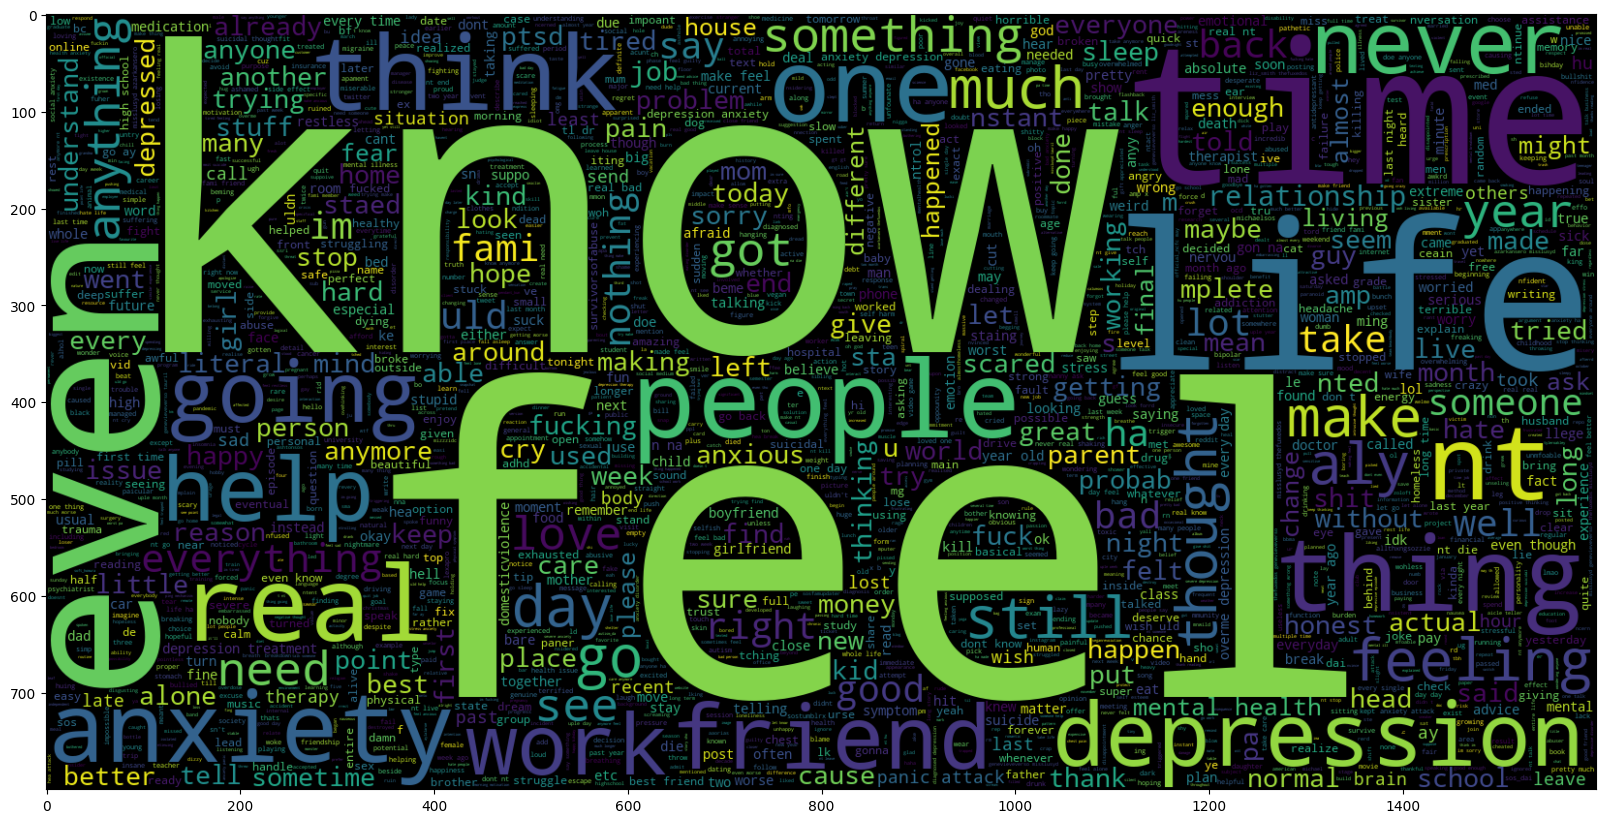

In [23]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc, interpolation='bilinear')

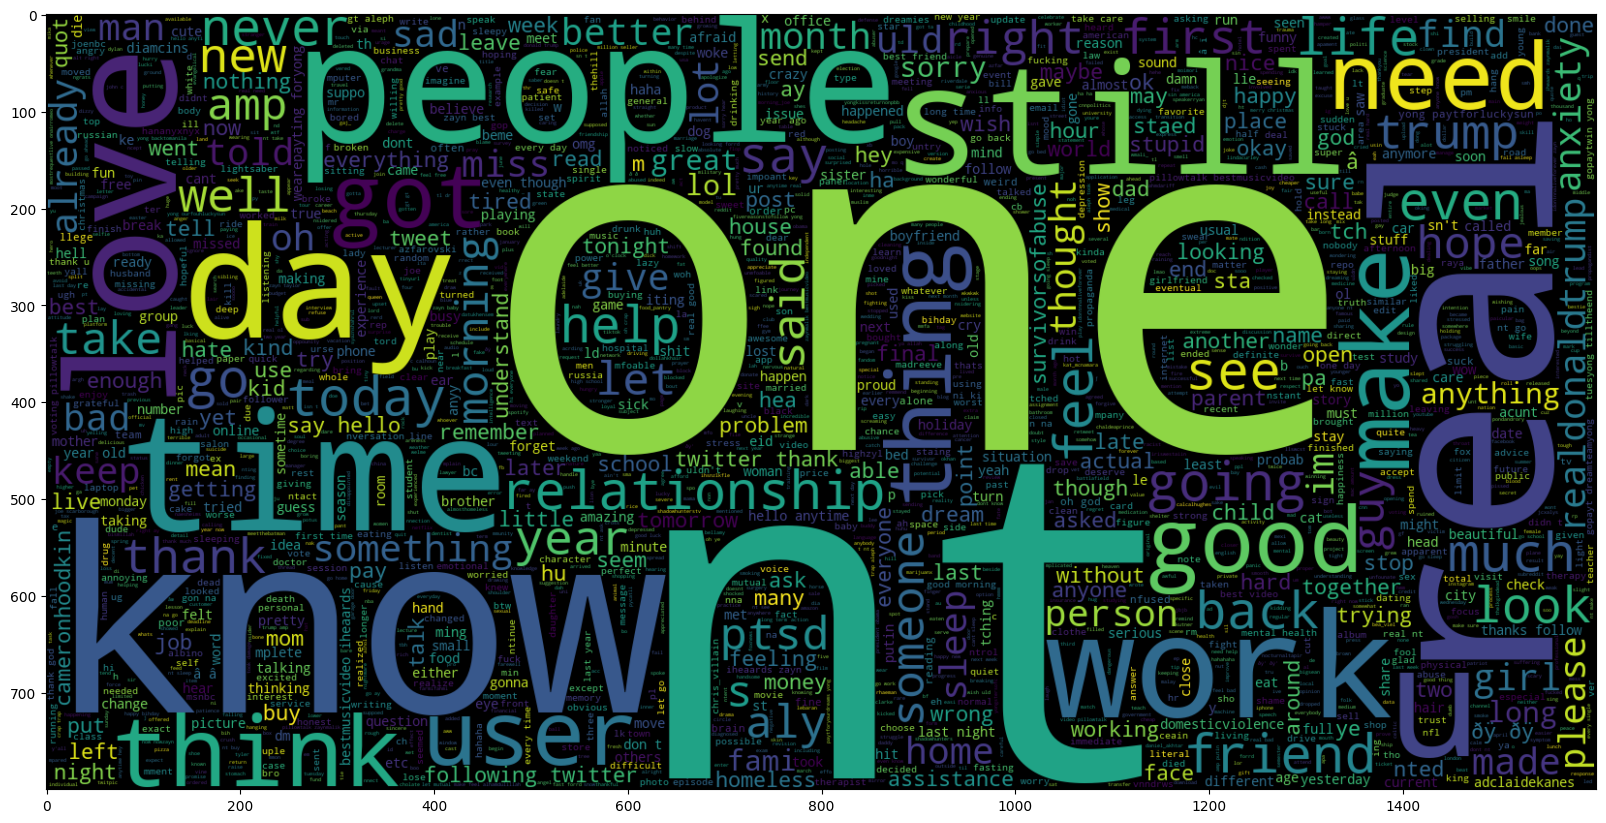

In [24]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc, interpolation='bilinear')

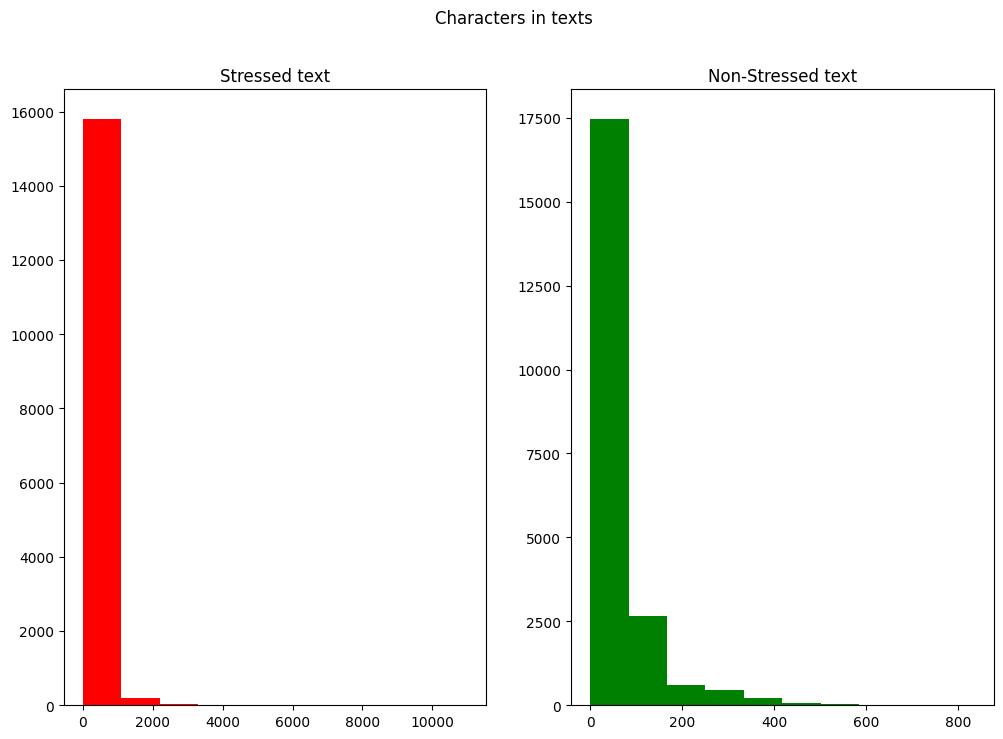

In [25]:
# Jumlah karakter pada text
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

text_len=df[df['label'] == 1]['text'].str.len()
ax1.hist(text_len, color='red')
ax1.set_title('Stressed text')

text_len=df[df['label'] == 0]['text'].str.len()
ax2.hist(text_len, color='green')
ax2.set_title('Non-Stressed text')

fig.suptitle('Characters in texts')
plt.show()

## Get top text

In [26]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

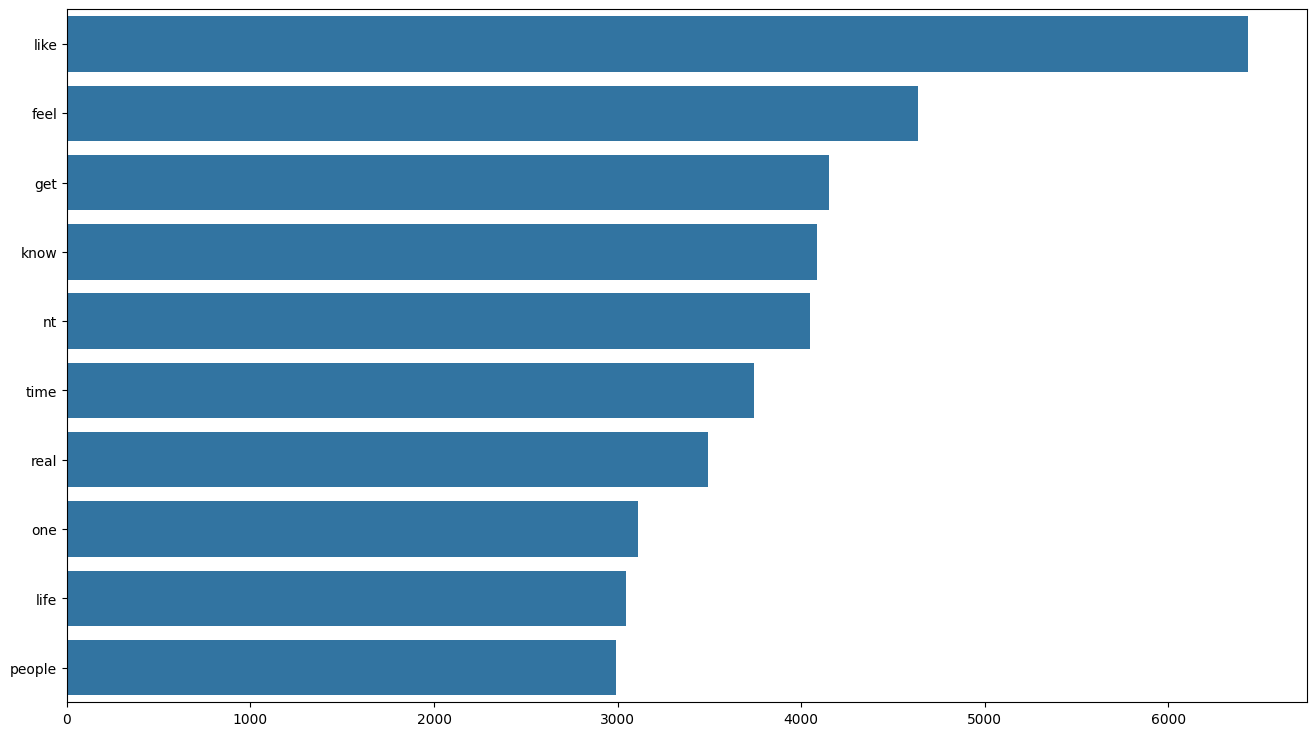

In [27]:
# Analisis unigram
plt.figure(figsize=(16, 9))
most_common_uni = get_top_text_ngrams(df['text'], 10, 1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))

<Axes: >

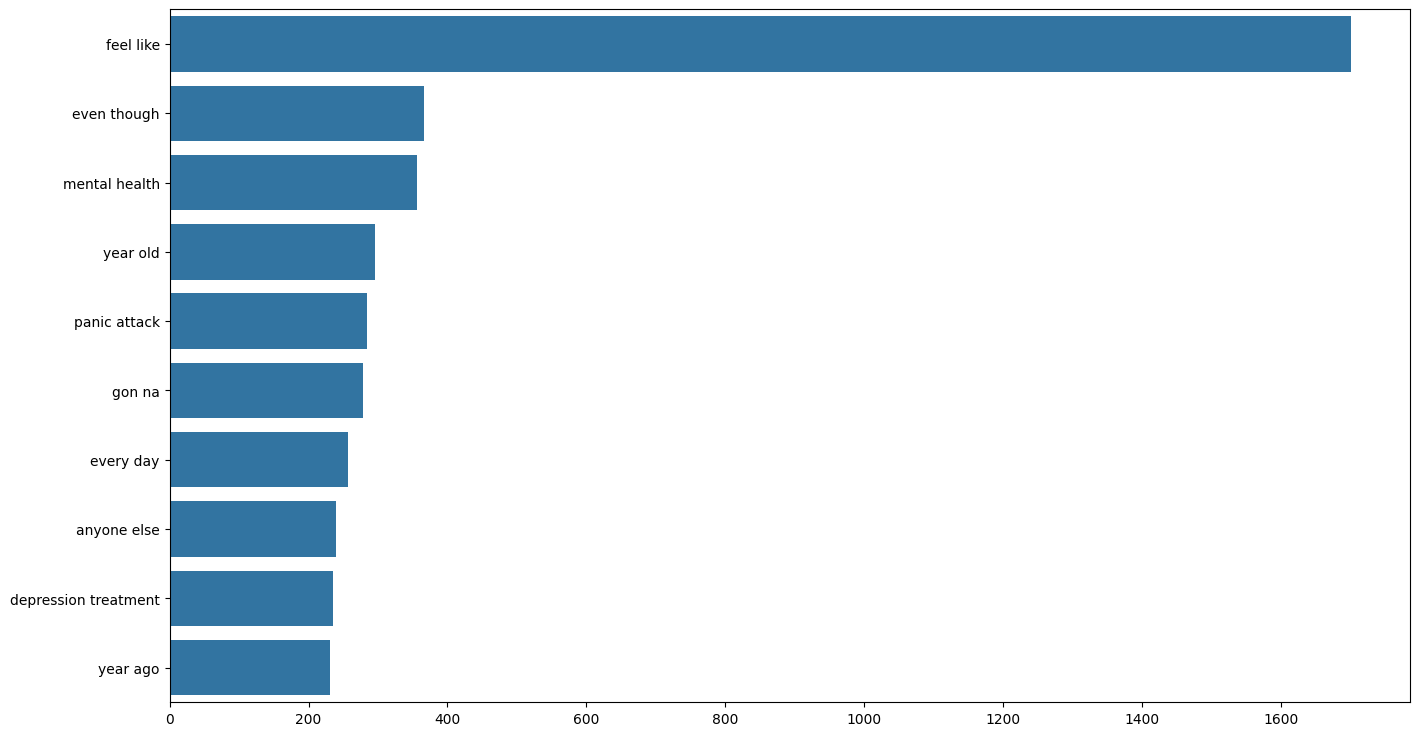

In [28]:
# Analiis bigram
plt.figure(figsize=(16, 9))
most_common_bi = get_top_text_ngrams(df['text'], 10, 2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()), y=list(most_common_bi.keys()))

In [29]:
# to csv
df.to_csv('../dataset/stress_cleaned.csv', index=False)

# Modelling

In [30]:
df = pd.read_csv('../dataset/stress_cleaned.csv')
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37516 entries, 0 to 37538
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    37516 non-null  object
 1   label   37516 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 879.3+ KB


## Oversampling

In [31]:
df.dropna(inplace=True)

count_vect  = CountVectorizer(ngram_range=(1, 1))
transformer = TfidfTransformer()

df_tfidf = transformer.fit_transform(
    count_vect.fit_transform(df['text'])
)

ros = RandomOverSampler(random_state=1000)
X_train_res, y_train_res = ros.fit_resample(df_tfidf, df['label'])

X_train_res.shape, y_train_res.shape

((42952, 40244), (42952,))

In [32]:
inverse_vocab = count_vect.inverse_transform(X_train_res)

resampled_texts = [' '.join(words) for words in inverse_vocab]

df = pd.DataFrame({
    'text': resampled_texts,
    'label': y_train_res
})

df.head()

,text,label
0,youi worried various uld trigger top to test s...,1
1,you would working win we untry undergrad three...,0
2,you yesterday year would violence vibe univers...,1
3,wont urse truth touch time thinking think thin...,1
4,years year violence verbal unable survivorsofa...,1


In [35]:
df.to_csv('../dataset/stress_resampled.csv', index=False)

In [34]:
df = pd.read_csv('../dataset/stress_resampled.csv')

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Tokenizing

In [5]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

tokenizer_json = tokenizer.to_json()
with open('../saved model/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(tokenized_train, maxlen=600)
X_test = pad_sequences(tokenized_test, maxlen=600)

In [6]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

## Training model

In [7]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_binary_accuracy', 
    patience=5, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001 
)

early_stopping = EarlyStopping(
    monitor='val_binary_accuracy', 
    patience=3, 
    verbose=1, 
    restore_best_weights=True
)

csv_logger = CSVLogger('../saved model/training.csv')

callback = [learning_rate_reduction, csv_logger, early_stopping]

In [8]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['binary_accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [10]:
history = model.fit(
    X_train, 
    y_train,  
    validation_data=(X_test, y_test), 
    epochs=5, 
    callbacks=callback
)

Epoch 1/5
938/938 [==============================] - 953s 1s/step - loss: 0.4085 - binary_accuracy: 0.8136 - val_loss: 0.3255 - val_binary_accuracy: 0.8546 - lr: 0.0010
Epoch 2/5
938/938 [==============================] - 844s 900ms/step - loss: 0.2222 - binary_accuracy: 0.9086 - val_loss: 0.3205 - val_binary_accuracy: 0.8681 - lr: 0.0010
Epoch 3/5
938/938 [==============================] - 798s 851ms/step - loss: 0.1349 - binary_accuracy: 0.9475 - val_loss: 0.4016 - val_binary_accuracy: 0.8623 - lr: 0.0010
Epoch 4/5
938/938 [==============================] - 829s 884ms/step - loss: 0.0874 - binary_accuracy: 0.9649 - val_loss: 0.5280 - val_binary_accuracy: 0.8601 - lr: 0.0010
Epoch 5/5
938/938 [==============================] - 930s 992ms/step - loss: 0.0665 - binary_accuracy: 0.9719 - val_loss: 0.6289 - val_binary_accuracy: 0.8513 - lr: 0.0010
Epoch 5: early stopping


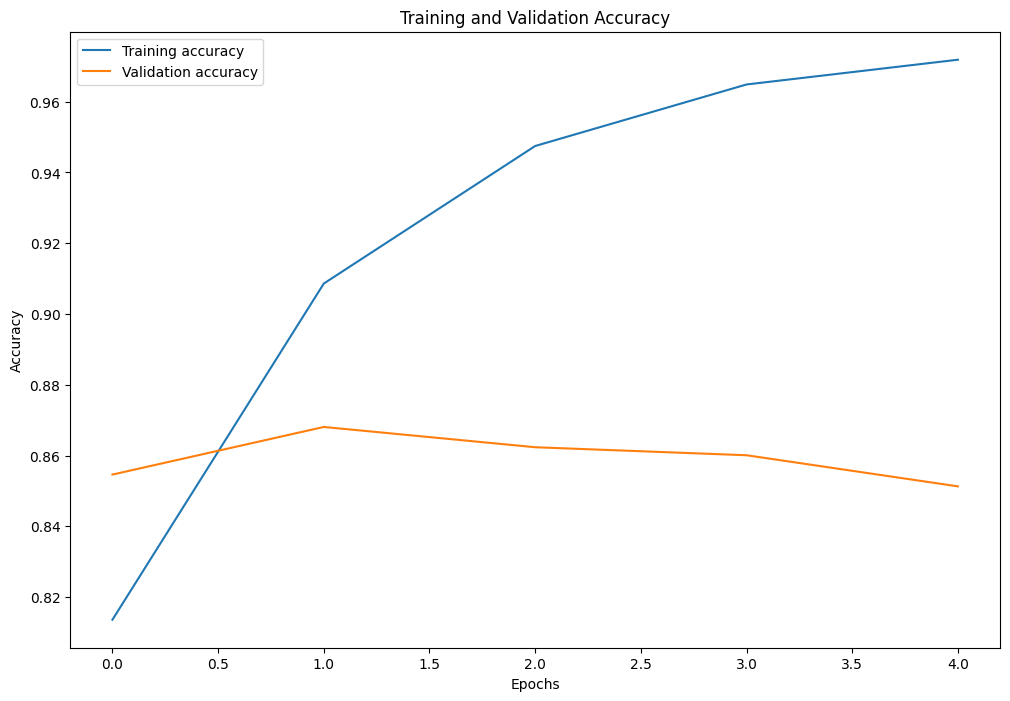

In [11]:
# plot history
plt.figure(figsize=(12, 8))
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.32050561904907227
Test accuracy: 0.8680703639984131


In [13]:
# save model
model.save('../saved model/bi_lstm_model.h5')

# Testing

In [7]:
import nltk
import keras
import re
import tensorflow as tf
import string

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from keras_preprocessing.text import tokenizer_from_json
from keras_preprocessing.sequence import pad_sequences

In [8]:
def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|rt|wa|co|bit|ly', '', text)
    return text

def wnl_lemmatize(text):
    wnl = WordNetLemmatizer()
    text = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(text)

def predict_stress(text):
    model = tf.keras.models.load_model('../saved model/bi_lstm_model.h5')
    
    text = preprocess_text(text)
    text = remove_stopwords(text)
    text = wnl_lemmatize(text)
    
    with open('../saved model/tokenizer.json') as f:
        data = f.read()
        tokenizer = tokenizer_from_json(data)
    
    tokenized = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(tokenized, maxlen=400)
    text = tf.convert_to_tensor(padded)
    
    prediction = model.predict(text)
    return prediction[0][0]

pos_text = "I'm very happy today, because I got a satisfactory grade, and my friends supported me a lot."
neg_text = "I'm Feeling depression, sadness, and disappointment is an indescribable experience. Every day feels like a weight that can't quite be lifted, accompanied by a gnawing sense of emptiness inside."
predict_stress(pos_text)

1/1 [==============================] - 2s 2s/step


0.37021518

In [ ]:
# stopwords = set(nltk.corpus.stopwords.words('english'))
# wnl = nltk.stem.WordNetLemmatizer()

# def preprocess(text):
#     # preprocess html tag
#     text = re.sub(r'<.*?>', '', text)
#     # preprocess non-alphabet
#     text = re.sub(r'[^a-zA-Z]', ' ', text)
#     # lowercase
#     text = text.lower()
#     # remove stopwords
#     text = ' '.join([word for word in text.split() if word not in stopwords])
#     # wnlemmatizer
#     text = ' '.join([wnl.lemmatize(word) for word in text.split()])
#     # remove extra space
#     text = re.sub(r'\s+', ' ', text)
#     # remove punctuation
#     text = re.sub(r'[^\w\s]', '', text)
#     # remove some words
#     text = re.sub(r'http|co|www|com|pic|bit|ly|wa|rt|nt', '', text)
    
#     return text

# def testing(text):
#     text = preprocess(text)
#     with open('../saved model/tokenizer.json') as f:
#         data = f.read()
#         tokenizer = tokenizer_from_json(data)
    
#     tokenized = tokenizer.texts_to_sequences([text])
#     tokenized = pad_sequences(tokenized, maxlen=400)
    
#     model = keras.models.load_model('../saved model/bi_lstm_model.h5')
#     prediction = model.predict(tokenized)[0]
    
#     return round(prediction[0], 2)*100

# pos_text = "I'm very happy today, because I got a satisfactory grade, and my friends supported me a lot."
# neg_text = "I'm Feeling depression, sadness, and disappointment is an indescribable experience. Every day feels like a weight that can't quite be lifted, accompanied by a gnawing sense of emptiness inside."

# print("Tingkat stress: ", testing(pos_text), "%")
# print("Tingkat stress: ", testing(neg_text), "%")